In [1]:
import pywph as pw
import numpy as np
import torch
import torch.utils.data as data_utils
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso
import sklearn
import matplotlib.pyplot as plt
# Device Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dark matter only simulations

## Data construction

### data load

In [79]:
sim = "Gadget"
fmaps =\
        "/mnt/ceph/users/fvillaescusa/Nbody_systematics/data/maps/maps_{}/Images_M_{}_LH_z=0.00.npy".format(sim,sim)
maps = np.load(fmaps)
grid_2d = np.log10(maps)
del maps

### Wavelet phase harmonics for only 1000 images out of 15000 images

In [21]:
try:
    coef
    del coef
except NameError:
    pass
M, N = 256, 256
J = 7
L = 4
dn = 0
wph_op = pw.WPHOp(M, N, J, L=L, dn=dn, device=0)
batch_size = 100
N = int(1000/batch_size)
for i in range(N):
    wph = wph_op(grid_2d[100*i*15:100*(i+1)*15:15,:,:])
    try:
        coef[100*i:100*(i+1),:] = wph.cpu().detach().numpy()
    except:
        num_coeffs = wph.shape[1]
        coef = np.zeros((1000,num_coeffs), dtype=np.complexfloating)
        coef[100*i:100*(i+1),:] = wph.cpu().detach().numpy()
np.save("../data/wph_dmo_for_regression",coef)

/tmp/ipykernel_262987/3111539897.py:19: DeprecationWarning: Converting `np.complex` to a dtype is deprecated. The current result is `complex128` which is not strictly correct.
  coef = np.zeros((1000,num_coeffs), dtype=np.complexfloating)


### WPH for the entire suite (15000 images)

In [80]:
M, N = 256, 256
J = 7
L = 4
dn = 0
try:
    coef
    del coef
except NameError:
    pass
wph_op = pw.WPHOp(M, N, J, L=L, dn=dn, device=0)
batch_size = 100
N = int(15000/batch_size)
for i in range(N):
    wph = wph_op(grid_2d[batch_size*i:batch_size*(i+1),:,:])
    try:
        coef[batch_size*i:batch_size*(i+1),:] = wph.cpu().detach().numpy()
    except:
        num_coeffs = wph.shape[1]
        coef = np.zeros((N*batch_size,num_coeffs), dtype=np.complexfloating)
        coef[batch_size*i:batch_size*(i+1),:] = wph.cpu().detach().numpy()
np.save("../data/wph_dmo_for_regression_total",coef)

/tmp/ipykernel_262987/2325229638.py:19: DeprecationWarning: Converting `np.complex` to a dtype is deprecated. The current result is `complex128` which is not strictly correct.
  coef = np.zeros((N*batch_size,num_coeffs), dtype=np.complexfloating)


### Normalized data

In [9]:
maps = grid_2d
nmaps = maps.reshape(maps.shape[0],-1)
nmaps = (nmaps.T - nmaps.mean(axis=1))/nmaps.std(axis=1)
#nmaps = (nmaps.T - nmaps.min(axis=1))/(nmaps.max(axis=1)-nmaps.min(axis=1))
nmaps = nmaps.T.reshape(15000,256,256)
m = maps.mean(axis=1).mean(axis=1); n = nmaps.mean(axis=1).mean(axis=1)
fparam = "/mnt/ceph/users/fvillaescusa/Nbody_systematics/data/maps/maps_Gadget/params_Gadget.txt"
params = np.loadtxt(fparam)[:,0]

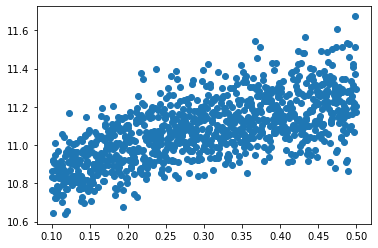

In [10]:
plt.scatter(params, m[::15])

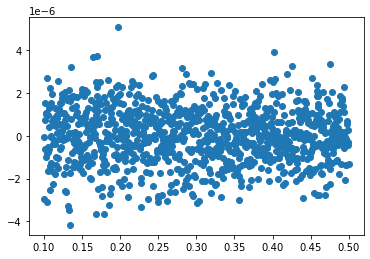

In [11]:
plt.scatter(params, n[::15])

In [81]:
J = 7; L = 4; dn = 0
maps = grid_2d
nmaps = maps.reshape(maps.shape[0],-1)
nmaps = (nmaps.T - nmaps.mean(axis=1))/nmaps.std(axis=1)
#nmaps = (nmaps.T - nmaps.min(axis=1))/(nmaps.max(axis=1)-nmaps.min(axis=1)
nmaps = nmaps.T.reshape(15000,256,256)

M, N = 256, 256
J = 7
L = 4
dn = 0
try: 
    del coef
except:
    pass
wph_op = pw.WPHOp(M, N, J, L=L, dn=dn, device=0)
batch_size = 100
N = int(15000/batch_size)
for i in range(N):
    wph = wph_op(nmaps[batch_size*i:batch_size*(i+1),:,:])
    try:
        coef[batch_size*i:batch_size*(i+1),:] = wph.cpu().detach().numpy()
    except:
        num_coeffs = wph.shape[1]
        coef = np.zeros((N*batch_size,num_coeffs), dtype=np.complexfloating)
        coef[batch_size*i:batch_size*(i+1),:] = wph.cpu().detach().numpy()
np.save("../data/wph_ndmo_for_regression_total",coef)

/tmp/ipykernel_262987/1108409037.py:25: DeprecationWarning: Converting `np.complex` to a dtype is deprecated. The current result is `complex128` which is not strictly correct.
  coef = np.zeros((N*batch_size,num_coeffs), dtype=np.complexfloating)


## Linear Correlation

In [13]:
import scipy
def getLinearCoef(coef,param):
    r = []
    for i in range(coef.shape[1]):
        r.append(scipy.stats.pearsonr(coef[:,i], param)[0])
    return np.array(r)

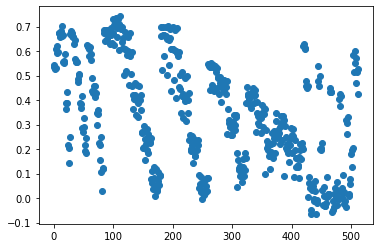

In [15]:
coef   = np.load("../data/wph_dmo_for_regression.npy")
r = getLinearCoef(np.real(coef),params)
plt.scatter(range(r.shape[0]),r)

/mnt/sw/nix/store/z6v265ivx5w6xbajay41vdfc0la8gla5-python-3.9.12-view/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


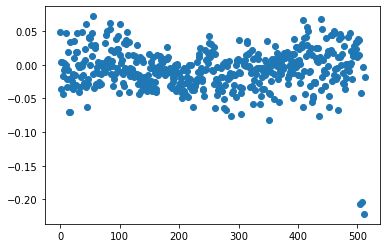

In [16]:
r = getLinearCoef(np.imag(coef),params)
plt.scatter(range(r.shape[0]),r)

## Linear Regression

In [82]:
fparam = "/mnt/ceph/users/fvillaescusa/Nbody_systematics/data/maps/maps_Gadget/params_Gadget.txt"
params = np.loadtxt(fparam)[:,:2]

In [5]:
def linear_regression(coef, params,alpha=1e-6, model=None):
    coef_r = np.absolute(coef).astype(float)

    batch_size = 50
    validation_split = .1
    shuffle_dataset = True
    random_seed = 4

    # Creating data indices for training and validation splits:
    y = torch.tensor(params,dtype=torch.float)
    X = torch.tensor(coef_r,dtype=torch.float)
    dataset      = data_utils.TensorDataset(X, y)
    dataset_size = len(dataset)
    indices      = list(range(dataset_size))
    split        = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)

    train_loader  = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    test_dataset      = data_utils.TensorDataset(X[val_indices], y[val_indices])
    if model is None:
        model = Ridge(alpha = alpha, tol =1e-7, max_iter=1e4,
                      solver ='auto', random_state = 100)
    model.fit(X[train_indices],y[train_indices])
    y_pred=model.predict(X[val_indices])
    y_test = y[val_indices]
    rel = np.abs(y_test-y_pred)/y_test *100
    rel = rel.mean(axis=0)
    r2  = sklearn.metrics.r2_score(y_test,y_pred)
    print("Relative error = {} / R2 score = {}".format(rel,r2))
    return model, test_dataset

### Regresion for 1000 coefficient sets

In [99]:
coef   = np.load("../data/wph_dmo_for_regression.npy")
_, _ = linear_regression(coef,params[:,0], alpha=1e-7) # Omega_m
_, _ = linear_regression(coef,params[:,1], alpha=1e-6) # Sigma8

Relative error = 18.972439692129683 / R2 score = 0.7172748140514869
Relative error = 7.566504524225979 / R2 score = 0.6032479893264424


### Regression for CV averaged coefficients: averaged 1000 coefficient sets out of 15000 images 

In [146]:
coef   = np.load("../data/wph_dmo_for_regression_total.npy")
coef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    coef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)

lin, test_dataset = linear_regression(coef_avg,params[:,0], alpha=1e-9) # Omega_m
_, _ = linear_regression(coef_avg,params[:,1], alpha=1e-7) # Sigma8

/tmp/ipykernel_262987/4031446667.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  coef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)


Relative error = 7.732775178215808 / R2 score = 0.9491517849769787
Relative error = 3.7176250447084755 / R2 score = 0.8987816678995889


### Regression for normalized CV averaged coefficients

In [139]:
coef   = np.load("../data/wph_ndmo_for_regression_total.npy")
coef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    coef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)

lin, test_dataset = linear_regression(coef_avg,params[:,0], alpha=1e-5) # Omega_m
_, _ = linear_regression(coef_avg,params[:,1], alpha=1e-6) # Sigma8

/tmp/ipykernel_262987/2673449186.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  coef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)


Relative error = 11.527046982879362 / R2 score = 0.9031434596249093
Relative error = 3.502377293350753 / R2 score = 0.9174173238299564


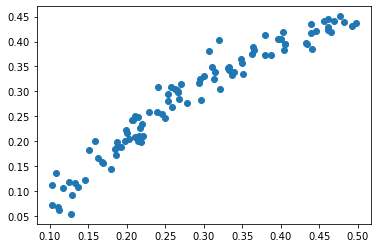

In [39]:
X,y = test_dataset.tensors
y_pred=lin.predict(X)
plt.scatter(y,y_pred)
plt.show()

# Hydrodynamic simulations

## Data construction

### data load

In [31]:
fmaps = \
        "/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/Maps_Mtot_IllustrisTNG_LH_z=0.00.npy"
# read the data
maps = np.load(fmaps)
grid_2d = np.log10(maps)
del maps

### Wavelet phase harmonics for only 1000 images out of 15000 images

In [32]:
M, N = 256, 256
J = 7
L = 4
dn = 0
try:
    coef
    del coef
except NameError:
    pass
wph_op = pw.WPHOp(M, N, J, L=L, dn=dn, device=0)
batch_size = 100
N = int(1000/batch_size)
for i in range(N):
    wph = wph_op(grid_2d[100*i*15:100*(i+1)*15:15,:,:])
    try:
        coef[100*i:100*(i+1),:] = wph.cpu().detach().numpy()
    except:
        num_coeffs = wph.shape[1]
        coef = np.zeros((1000,num_coeffs), dtype=np.complexfloating)
        coef[100*i:100*(i+1),:] = wph.cpu().detach().numpy()
np.save("../data/wph_hydro_for_regression",coef)

/tmp/ipykernel_262987/3374682806.py:19: DeprecationWarning: Converting `np.complex` to a dtype is deprecated. The current result is `complex128` which is not strictly correct.
  coef = np.zeros((1000,num_coeffs), dtype=np.complexfloating)


### WPH for the entire suite (15000 images)

In [34]:
M, N = 256, 256
J = 7
L = 4
dn = 0
try:
    coef
    del coef
except NameError:
    pass
wph_op = pw.WPHOp(M, N, J, L=L, dn=dn, device=0)
batch_size = 100
N = int(15000/batch_size)
for i in range(N):
    wph = wph_op(grid_2d[batch_size*i:batch_size*(i+1),:,:])
    try:
        coef[batch_size*i:batch_size*(i+1),:] = wph.cpu().detach().numpy()
    except:
        num_coeffs = wph.shape[1]
        coef = np.zeros((N*batch_size,num_coeffs), dtype=np.complexfloating)
        coef[batch_size*i:batch_size*(i+1),:] = wph.cpu().detach().numpy()
np.save("../data/wph_hydro_for_regression_total",coef)

/tmp/ipykernel_262987/3319345148.py:19: DeprecationWarning: Converting `np.complex` to a dtype is deprecated. The current result is `complex128` which is not strictly correct.
  coef = np.zeros((N*batch_size,num_coeffs), dtype=np.complexfloating)


### Normalized data

In [35]:
J = 7; L = 4; dn = 0
maps = grid_2d
nmaps = maps.reshape(maps.shape[0],-1)
nmaps = (nmaps.T - nmaps.mean(axis=1))/nmaps.std(axis=1)
#nmaps = (nmaps.T - nmaps.min(axis=1))/(nmaps.max(axis=1)-nmaps.min(axis=1)
nmaps = nmaps.T.reshape(15000,256,256)

M, N = 256, 256
J = 7
L = 4
dn = 0
try:
    coef
    del coef
except NameError:
    pass
wph_op = pw.WPHOp(M, N, J, L=L, dn=dn, device=0)
batch_size = 100
N = int(15000/batch_size)
for i in range(N):
    wph = wph_op(nmaps[batch_size*i:batch_size*(i+1),:,:])
    try:
        coef[batch_size*i:batch_size*(i+1),:] = wph.cpu().detach().numpy()
    except:
        num_coeffs = wph.shape[1]
        coef = np.zeros((N*batch_size,num_coeffs), dtype=np.complexfloating)
        coef[batch_size*i:batch_size*(i+1),:] = wph.cpu().detach().numpy()
np.save("../data/wph_nhydro_for_regression_total",coef)

/tmp/ipykernel_262987/2624332418.py:26: DeprecationWarning: Converting `np.complex` to a dtype is deprecated. The current result is `complex128` which is not strictly correct.
  coef = np.zeros((N*batch_size,num_coeffs), dtype=np.complexfloating)


## Linear regression

In [24]:
fparams = '/mnt/home/fvillaescusa/CAMELS/PUBLIC_RELEASE/CMD/2D_maps/data/params_IllustrisTNG.txt'
params = np.loadtxt(fparams)

### Regresion for 1000 coefficient sets

In [77]:
coef   = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_hydro_for_regression.npy")
_, _ = linear_regression(coef,params[:,0], alpha=1e-7) # Omega_m
_, _ = linear_regression(coef,params[:,1], alpha=1e-6) # Sigma8

Relative error = 11.364890970776923 / R2 score = 0.880817030527881
Relative error = 6.011281710273241 / R2 score = 0.7184507569833289


### Regression for CV averaged coefficients: averaged 1000 coefficient sets out of 15000 images 

In [64]:
coef   = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_hydro_for_regression_total.npy")
coef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    coef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)

lin, test_dataset = linear_regression(coef_avg,params[:,0], alpha=1e-8) # Omega_m
_, _ = linear_regression(coef_avg,params[:,1], alpha=1e-8) # Sigma8

/tmp/ipykernel_262987/2139627529.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  coef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)


Relative error = 5.873881848305415 / R2 score = 0.9673851435781771
Relative error = 2.612380532866977 / R2 score = 0.9413017018240144


### Regression for normalized CV averaged coefficients

In [45]:
coef   = np.load("/mnt/home/yjo10/ceph/CAMELS/MIEST/data/wph_nhydro_for_regression_total.npy")
coef_avg = np.zeros((1000, coef.shape[1]))
for i in range(1000):
    coef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)

lin, test_dataset = linear_regression(coef_avg,params[:,0], alpha=1e-6) # Omega_m
_, _ = linear_regression(coef_avg,params[:,1], alpha=1e-7) # Sigma8

/tmp/ipykernel_262987/3237246012.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  coef_avg[i,:] = coef[i*15:i*15+15,:].mean(axis=0)


Relative error = 9.205798331881036 / R2 score = 0.9322563635828023
Relative error = 2.9560806920554956 / R2 score = 0.9330478647781635


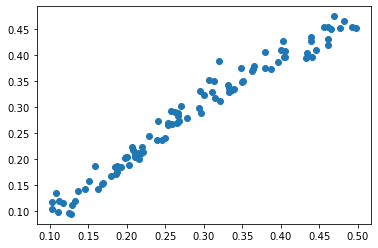

In [65]:
X,y = test_dataset.tensors
y_pred=lin.predict(X)
plt.scatter(y,y_pred)
plt.show()